In [2]:

import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams["axes.unicode_minus"] = False


# CSV 파일 불러오기
file_path = 'data/kc/chinese_factories.csv'
df = pd.read_csv(file_path)

df.info()

/var/folders/q0/9z_mzpps4v5f03vr8vrq6xk00000gn/T/ipykernel_61184/3587154423.py:10: DtypeWarning: Columns (0,5,10,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 477291 entries, 0 to 477290
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   certUid                 477288 non-null  object 
 1   certOrganName           477291 non-null  object 
 2   certNum                 477291 non-null  object 
 3   certState               477289 non-null  object 
 4   certDiv                 477291 non-null  object 
 5   certDate                477291 non-null  object 
 6   certChgDate             3 non-null       float64
 7   certChgReason           92728 non-null   object 
 8   firstCertNum            462966 non-null  object 
 9   productName             477237 non-null  object 
 10  brandName               7827 non-null    object 
 11  modelName               477282 non-null  object 
 12  categoryName            415712 non-null  object 
 13  importDiv               421186 non-null  object 
 14  makerName           

### 연도별 KC인증 수 추이

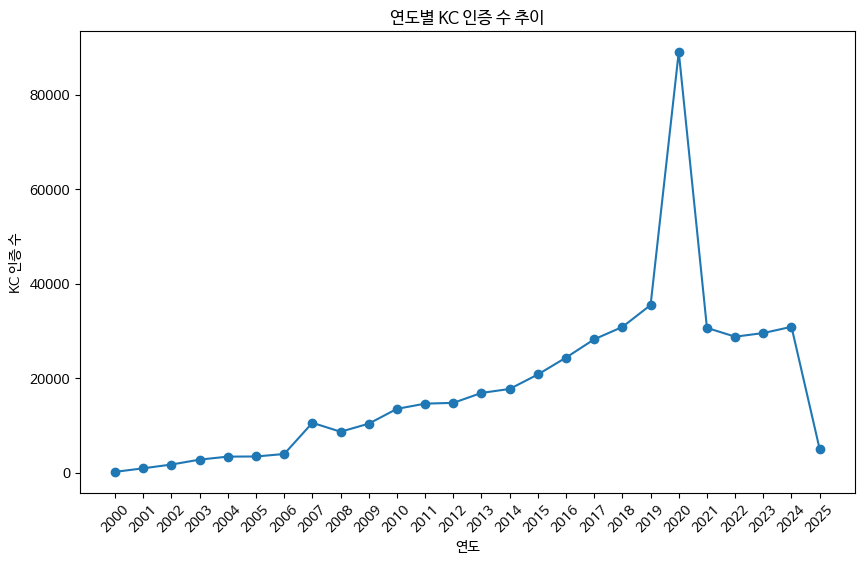

In [2]:

pattern = r'^\d{8}$'
df = df[df['certDate'].astype(str).str.match(pattern)]

df['year'] = df['certDate'].astype(str).str[:4]

# 연도별 리포트 개수 집계
year_counts = df.groupby('year').size().reset_index(name='report_count')

# 연도 순으로 정렬 (문자열 정렬일 경우 숫자로 변환 후 정렬하면 더 정확할 수 있습니다)
year_counts['year'] = year_counts['year'].astype(int)
year_counts = year_counts.sort_values('year')

# matplotlib을 이용해 추이 시각화
plt.figure(figsize=(10, 6))
plt.plot(year_counts['year'], year_counts['report_count'], marker='o')
plt.xlabel('연도')
plt.ylabel('KC 인증 수')
plt.title('연도별 KC 인증 수 추이')
plt.grid(False)
plt.xticks(year_counts['year'], rotation=45)  # 모든 연도를 x축에 표시하고 회전
plt.show()

### KC인증 상태 통계

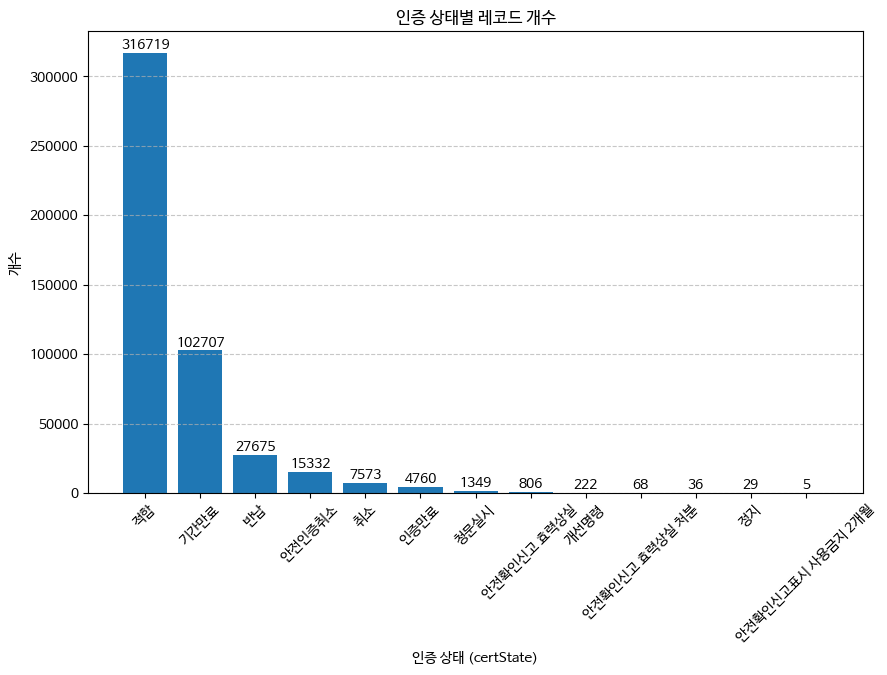

In [3]:
# certState 컬럼의 각 상태별 count 계산
state_counts = df['certState'].value_counts().reset_index()
state_counts.columns = ['certState', 'count']

# 막대그래프 시각화
plt.figure(figsize=(10, 6))
bars = plt.bar(state_counts['certState'], state_counts['count'])
plt.xlabel('인증 상태 (certState)')
plt.ylabel('개수')
plt.title('인증 상태별 레코드 개수')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 각 막대 위에 데이터 라벨 추가
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, height, 
        f'{int(height)}', ha='center', va='bottom'
    )

plt.show()

### 지역 이름이 포함된 공장 통계

In [4]:
df = df.dropna(subset=['makerName'])
df['makerName_upper'] = df['makerName'].str.upper()

# 대표적인 중국 제조지역 리스트 (모두 대문자)
regions = [
    'SHENZHEN', 'SHANGHAI', 'BEIJING', 'GUANGZHOU', 'CHENGDU',
    'TIANJIN', 'DONGGUAN', 'SUZHOU', 'WUHAN', 'CHONGQING'
]

# 각 지역 문자열이 포함된 unique makerName 개수를 nunique()로 계산
region_counts = {}
for region in regions:
    count = df[df['makerName_upper'].str.contains(region, na=False)]['makerName_upper'].nunique()
    region_counts[region] = count

# 결과를 DataFrame으로 정리하여 출력
region_counts_df = pd.DataFrame(list(region_counts.items()), columns=['Region', 'Unique Maker Count'])
print(region_counts_df)

      Region  Unique Maker Count
0   SHENZHEN                3703
1   SHANGHAI                 661
2    BEIJING                  81
3  GUANGZHOU                 635
4    CHENGDU                  23
5    TIANJIN                 368
6   DONGGUAN                2173
7     SUZHOU                 546
8      WUHAN                  21
9  CHONGQING                  40


### 공장 유사 이름 클러스터링 (실험단계)

In [5]:
import re
from rapidfuzz import fuzz
import json

unique_list = list(set(df['makerName_upper']))

# unique_list를 JSON 파일로 저장 (인코딩 및 indent 옵션 포함)
with open('unique_maker_names.json', 'w', encoding='utf-8') as f:
    json.dump(unique_list, f, ensure_ascii=False, indent=4)

df = df.dropna(subset=['makerName'])
df['makerName_upper'] = df['makerName'].str.upper()

# 고유 업체명 리스트 추출
unique_names = df['makerName_upper'].unique().tolist()

# 업체명 정규화 함수 정의: 불필요한 단어와 구두점 제거
def normalize_company_name(name):
    # 제거할 공통 단어 리스트 (필요에 따라 추가/수정 가능)
    common_words = ['CO LTD', 'LTD', 'INC', 'CORP', 'COMPANY', '유한공사', '주식회사', 'FACTORY', 'PLC']
    # 구두점 제거
    name = re.sub(r'[^\w\s]', '', name)
    # 각 불필요한 단어 제거
    for word in common_words:
        name = name.replace(word, '')
    # 여분의 공백 제거 후 반환
    return ' '.join(name.split())

# 정규화된 업체명 딕셔너리 생성: 원본 업체명 -> 정규화 업체명
normalized_names = {name: normalize_company_name(name) for name in unique_names}

# fuzzy matching을 이용한 클러스터링
clusters = {}  # {정규화 업체명 대표: [원본 업체명 목록]}
threshold = 100  # 유사도 임계값 (0~100 사이, 값이 클수록 엄격함)

for original, norm in normalized_names.items():
    added = False
    # 기존 클러스터와 비교하여 유사도가 임계값 이상이면 같은 그룹에 추가
    for rep in clusters:
        score = fuzz.ratio(norm, rep)
        if score >= threshold:
            clusters[rep].append(original)
            added = True
            break
    # 어떤 클러스터에도 속하지 않으면 새로운 클러스터 생성
    if not added:
        clusters[norm] = [original]

print(f"total cluster #: {len(clusters)}")
with open('cluster.json', 'w', encoding='utf-8') as f:
    json.dump(clusters, f, ensure_ascii=False, indent=4)

total cluster #: 34655


### KC인증 수 나라별 통계

makerCntryName 별 통계:
  makerCntryName   count
0             중국  418058


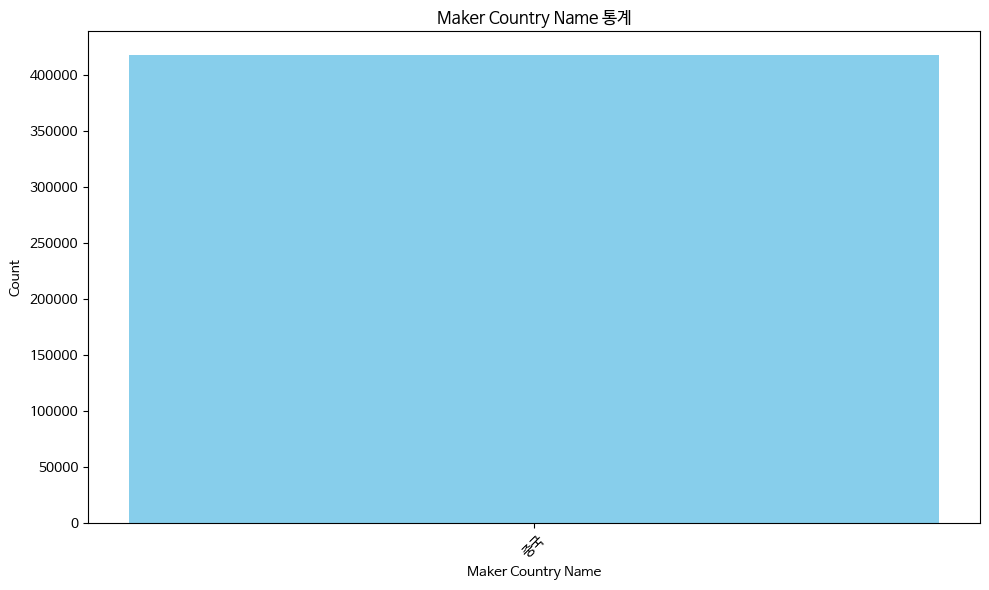

In [6]:
# makerCntryName 별 통계 내기
country_stats = df['makerCntryName'].value_counts().reset_index()
country_stats.columns = ['makerCntryName', 'count']

# 통계 출력
print("makerCntryName 별 통계:")
print(country_stats)

# 통계 시각화 (선택 사항)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(country_stats['makerCntryName'], country_stats['count'], color='skyblue')
plt.title('Maker Country Name 통계')
plt.xlabel('Maker Country Name')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()